# Data Preprocessing - LendingClub Loan Data

This notebook handles comprehensive data preprocessing including:
- Feature selection and engineering
- Missing value imputation
- Categorical encoding
- Feature scaling
- Train/validation/test splitting

In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from src.data.data_loader import LendingClubDataLoader
from src.data.preprocessor import LendingClubPreprocessor
from src.utils.helpers import setup_logging, print_data_summary, save_results
from config.config import DATA_CONFIG, NUMERICAL_FEATURES, CATEGORICAL_FEATURES

# Setup
setup_logging()
plt.style.use('seaborn-v0_8')

2025-09-11 15:49:08,955 - src.utils.helpers - INFO - Logging setup complete. Level: INFO


## 1. Load Data

In [2]:
# Load data from EDA
try:
    df = pd.read_csv('../data/processed/eda_processed_data.csv')
    print(f"Loaded preprocessed data: {df.shape}")
except FileNotFoundError:
    print("EDA data not found. Loading raw data...")
    data_loader = LendingClubDataLoader()
    df_raw = data_loader.load_raw_data(sample_size=DATA_CONFIG.sample_size)
    df = data_loader.create_binary_target(df_raw)
    print(f"Loaded and processed raw data: {df.shape}")

print_data_summary(df, "Data Before Preprocessing")

Loaded preprocessed data: (88399, 154)

Data Before Preprocessing
Shape: (88399, 154)
Memory usage: 243.70 MB

Data types:
float64    116
object      36
int64        2
Name: count, dtype: int64

Missing values:
                          Missing  Percentage
member_id                   88399  100.000000
revol_bal_joint             88399  100.000000
sec_app_fico_range_high     88399  100.000000
sec_app_earliest_cr_line    88399  100.000000
sec_app_inq_last_6mths      88399  100.000000
...                           ...         ...
last_pymnt_d                   71    0.080318
revol_util                     36    0.040724
last_credit_pull_d              3    0.003394
dti                             2    0.002262
num_rev_accts                   1    0.001131

[73 rows x 2 columns]

Numerical columns summary:
                 id  member_id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  8.839900e+04        0.0  88399.000000  88399.000000     88399.000000   
mean   6.533064e+07        N

## 2. Feature Selection

In [3]:
# Select features that exist in the dataset
available_numerical = [col for col in NUMERICAL_FEATURES if col in df.columns]
available_categorical = [col for col in CATEGORICAL_FEATURES if col in df.columns]

print(f"Available numerical features: {len(available_numerical)}")
print(available_numerical)
print(f"\nAvailable categorical features: {len(available_categorical)}")
print(available_categorical)

# Select subset of features for modeling
selected_numerical = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
    'fico_range_low', 'fico_range_high', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc'
]
selected_numerical = [f for f in selected_numerical if f in df.columns]

selected_categorical = [
    'grade', 'home_ownership', 'verification_status', 'purpose'
]
selected_categorical = [f for f in selected_categorical if f in df.columns]

all_features = selected_numerical + selected_categorical + ['target']

print(f"\nSelected features for modeling:")
print(f"Numerical: {selected_numerical}")
print(f"Categorical: {selected_categorical}")
print(f"Total features: {len(all_features) - 1}")

# Filter dataframe to selected features
df_selected = df[all_features].copy()
print(f"\nDataset after feature selection: {df_selected.shape}")

Available numerical features: 25
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

Available categorical features: 10
['grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']

Selected features for modeling:
Numerical: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
Categorical: ['grade', 'home_ownership', 'verification_status', 'purpose']
Total features: 17

Dataset after feature selection: (

## 3. Data Quality Analysis

Missing values analysis:
                Feature  Missing_Count  Missing_Percentage Data_Type
0             loan_amnt              0                0.00   float64
1              int_rate              0                0.00   float64
2           installment              0                0.00   float64
3            annual_inc              0                0.00   float64
4                   dti              2                0.00   float64
5        fico_range_low              0                0.00   float64
6       fico_range_high              0                0.00   float64
7        inq_last_6mths              0                0.00   float64
8              open_acc              0                0.00   float64
9               pub_rec              0                0.00   float64
10            revol_bal              0                0.00   float64
11           revol_util             36                0.04   float64
12            total_acc              0                0.00   float64
13       

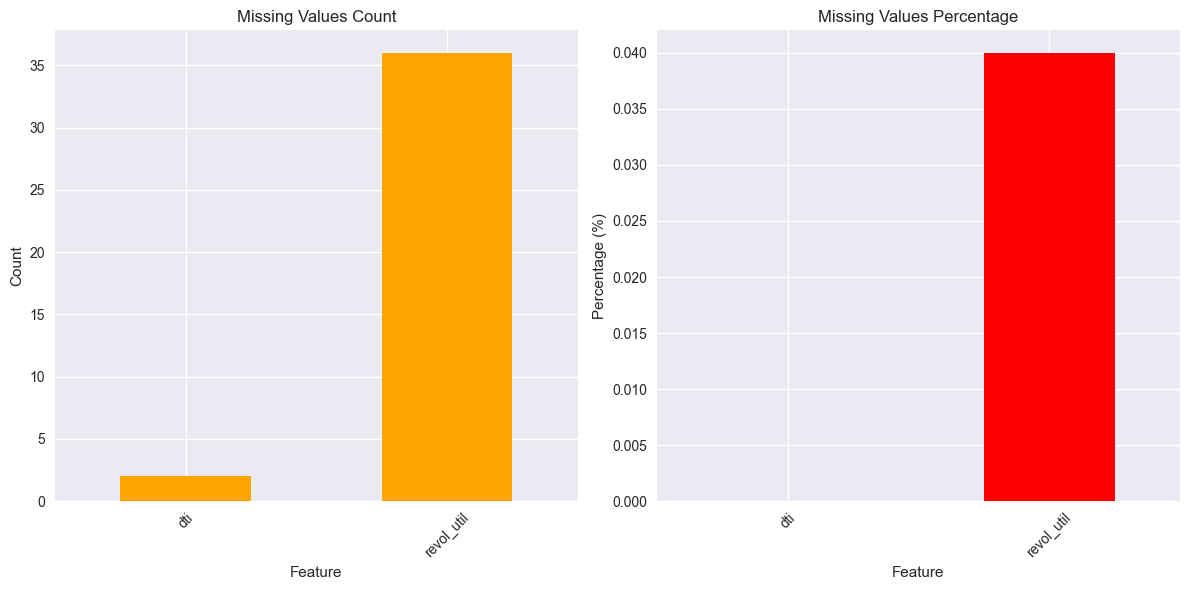

In [4]:
# Analyze missing values in selected features
missing_analysis = pd.DataFrame({
    'Feature': df_selected.columns,
    'Missing_Count': df_selected.isnull().sum().values,
    'Missing_Percentage': (df_selected.isnull().sum().values / len(df_selected) * 100).round(2),
    'Data_Type': df_selected.dtypes.values
})

print("Missing values analysis:")
print(missing_analysis)

# Visualize missing values
missing_features = missing_analysis[missing_analysis['Missing_Count'] > 0]
if len(missing_features) > 0:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    missing_features.set_index('Feature')['Missing_Count'].plot(kind='bar', color='orange')
    plt.title('Missing Values Count')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    missing_features.set_index('Feature')['Missing_Percentage'].plot(kind='bar', color='red')
    plt.title('Missing Values Percentage')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values in selected features!")

In [5]:
# Analyze data distributions before preprocessing
print("Statistical summary of numerical features:")
print(df_selected[selected_numerical].describe())

print("\nValue counts for categorical features:")
for feature in selected_categorical:
    print(f"\n{feature}:")
    print(df_selected[feature].value_counts())

Statistical summary of numerical features:
          loan_amnt      int_rate   installment    annual_inc           dti  \
count  88399.000000  88399.000000  88399.000000  8.839900e+04  88397.000000   
mean   14401.227955     11.963732    430.039399  7.768584e+04     18.997866   
std     8596.378418      4.132197    253.449762  8.949235e+04      9.698046   
min     1000.000000      5.320000     14.770000  0.000000e+00      0.000000   
25%     8000.000000      8.490000    245.520000  4.600000e+04     12.330000   
50%    12000.000000     11.530000    369.930000  6.500000e+04     18.420000   
75%    20000.000000     14.330000    572.190000  9.260400e+04     25.230000   
max    35000.000000     28.990000   1354.660000  9.000000e+06    999.000000   

       fico_range_low  fico_range_high  inq_last_6mths      open_acc  \
count    88399.000000     88399.000000    88399.000000  88399.000000   
mean       694.468999       698.469146        0.598932     11.864467   
std         31.081343        

## 4. Data Preprocessing Pipeline

In [6]:
# Initialize preprocessor
preprocessor = LendingClubPreprocessor()

# Update the preprocessor to use our selected features
preprocessor.numerical_features = selected_numerical
preprocessor.categorical_features = selected_categorical

# Fit and transform the data
print("Applying preprocessing pipeline...")
X_processed, y = preprocessor.fit_transform(df_selected)

print(f"Processed data shape: {X_processed.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")

2025-09-11 15:51:38,112 - src.data.preprocessor - INFO - Using 13 numerical and 4 categorical features


Applying preprocessing pipeline...


2025-09-11 15:51:38,723 - src.data.preprocessor - INFO - Processed data shape: (88399, 35)


Processed data shape: (88399, 35)
Target shape: (88399,)
Target distribution: [70288 18111]


In [7]:
# Get feature names after preprocessing
feature_names = preprocessor.feature_names
print(f"Total features after preprocessing: {len(feature_names)}")
print(f"\nFeature names: {feature_names[:10]}...")  # Show first 10

# Create DataFrame with processed features for analysis
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
X_processed_df['target'] = y

print("\nProcessed data summary:")
print(X_processed_df.describe())

Total features after preprocessing: 35

Feature names: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec']...

Processed data summary:
          loan_amnt      int_rate   installment    annual_inc           dti  \
count  8.839900e+04  8.839900e+04  8.839900e+04  8.839900e+04  8.839900e+04   
mean   5.626533e-17 -2.636433e-17 -4.147559e-17  6.092732e-17  1.982951e-16   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.558948e+00 -1.607806e+00 -1.638478e+00 -8.680773e-01 -1.958969e+00   
25%   -7.446466e-01 -8.406548e-01 -7.280356e-01 -3.540640e-01 -6.875576e-01   
50%   -2.793318e-01 -1.049645e-01 -2.371663e-01 -1.417541e-01 -5.958544e-02   
75%    6.512980e-01  5.726449e-01  5.608662e-01  1.666985e-01  6.426297e-01   
max    2.396229e+00  4.120414e+00  3.648162e+00  9.969975e+01  1.010532e+02   

       fico_range_low  fico_range_high  inq_last_6mths      open_

## 5. Data Splitting

In [8]:
# Split data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(X_processed, y)

print("Data splitting results:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")

print("\nTarget distribution in each set:")
print(f"Train - Class 0: {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%), Class 1: {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")
print(f"Val - Class 0: {np.sum(y_val == 0)} ({np.mean(y_val == 0)*100:.1f}%), Class 1: {np.sum(y_val == 1)} ({np.mean(y_val == 1)*100:.1f}%)")
print(f"Test - Class 0: {np.sum(y_test == 0)} ({np.mean(y_test == 0)*100:.1f}%), Class 1: {np.sum(y_test == 1)} ({np.mean(y_test == 1)*100:.1f}%)")

2025-09-11 15:51:52,128 - src.data.preprocessor - INFO - Data split - Train: 53039, Val: 17680, Test: 17680


Data splitting results:
Training set: 53039 samples (60.0%)
Validation set: 17680 samples (20.0%)
Test set: 17680 samples (20.0%)

Target distribution in each set:
Train - Class 0: 42172 (79.5%), Class 1: 10867 (20.5%)
Val - Class 0: 14058 (79.5%), Class 1: 3622 (20.5%)
Test - Class 0: 14058 (79.5%), Class 1: 3622 (20.5%)


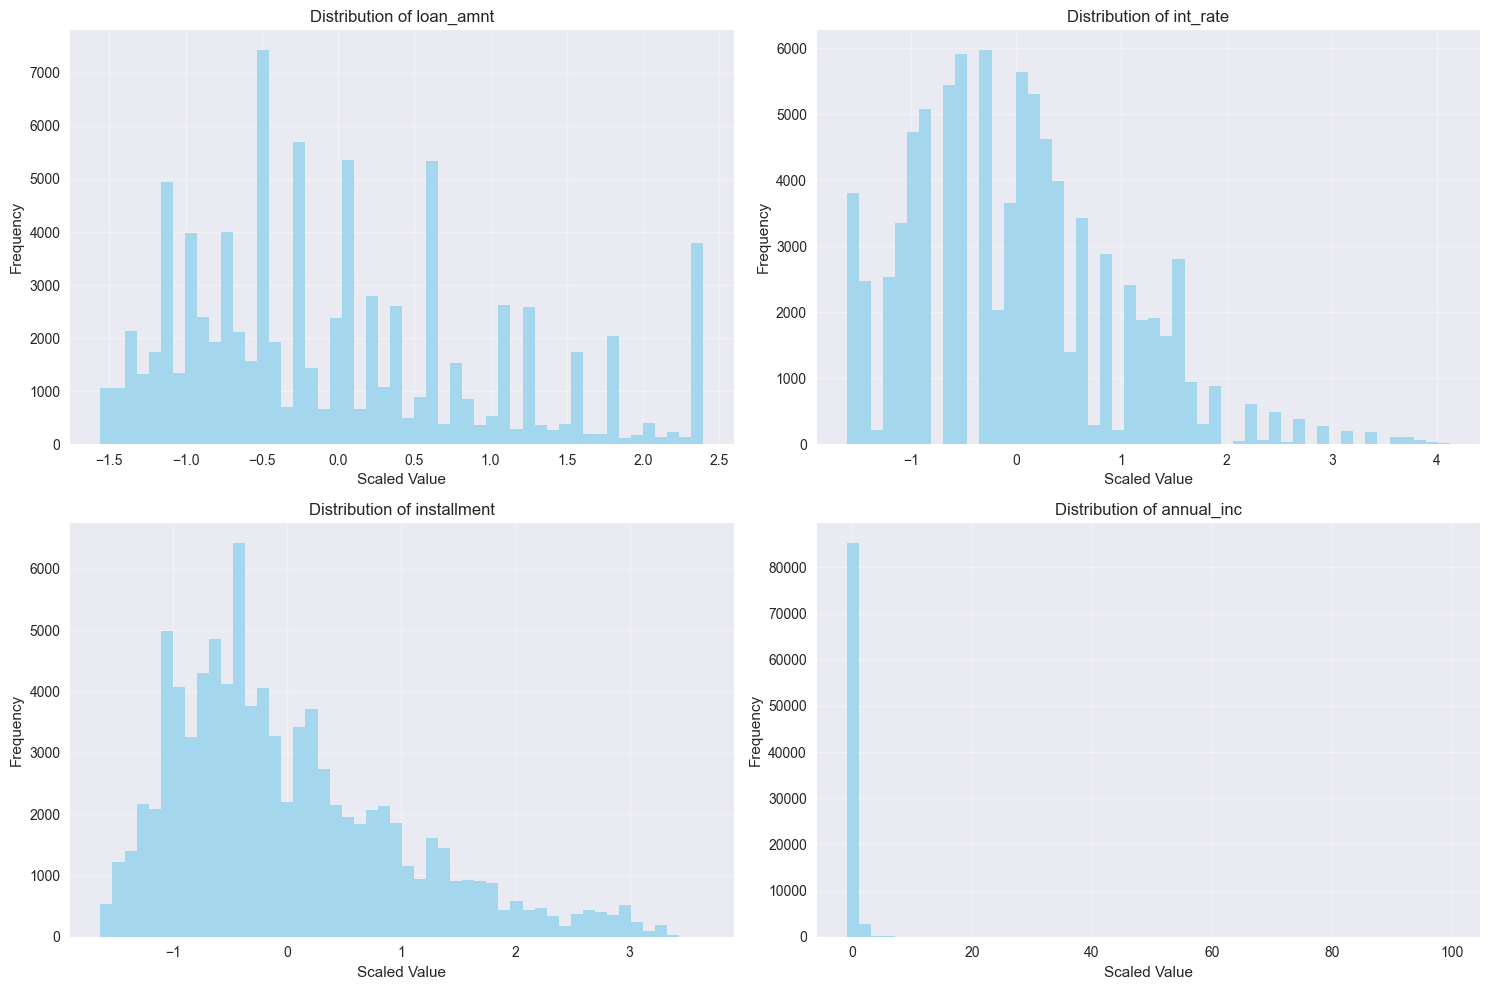

In [9]:
# Visualize data distribution after preprocessing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot distribution of first few processed features
for i in range(min(4, X_processed.shape[1])):
    row = i // 2
    col = i % 2
    
    axes[row, col].hist(X_processed[:, i], bins=50, alpha=0.7, color='skyblue')
    axes[row, col].set_title(f'Distribution of {feature_names[i]}')
    axes[row, col].set_xlabel('Scaled Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Save Preprocessed Data and Pipeline

In [10]:
# Create data dictionary for easy access
processed_data = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'feature_names': feature_names,
    'selected_numerical': selected_numerical,
    'selected_categorical': selected_categorical
}

# Save processed data
print("Saving preprocessed data...")
save_results(processed_data, 'preprocessed_data.pkl', '../data/processed/')

# Save the fitted preprocessor
joblib.dump(preprocessor, '../data/processed/preprocessor.pkl')
print("Preprocessor saved to '../data/processed/preprocessor.pkl'")

# Save original data with selected features for RL
df_for_rl = df_selected.copy()
df_for_rl.to_csv('../data/processed/data_for_rl.csv', index=False)
print("Original data for RL saved to '../data/processed/data_for_rl.csv'")

Saving preprocessed data...
Results saved to: ../data/processed/preprocessed_data.pkl
Preprocessor saved to '../data/processed/preprocessor.pkl'
Original data for RL saved to '../data/processed/data_for_rl.csv'


In [11]:
# Create preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'selected_features_shape': df_selected.shape,
    'processed_shape': X_processed.shape,
    'n_numerical_features': len(selected_numerical),
    'n_categorical_features': len(selected_categorical),
    'n_processed_features': len(feature_names),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'class_distribution': {
        'class_0': int(np.sum(y == 0)),
        'class_1': int(np.sum(y == 1)),
        'default_rate': float(np.mean(y))
    },
    'selected_features': {
        'numerical': selected_numerical,
        'categorical': selected_categorical
    }
}

save_results(preprocessing_summary, 'preprocessing_summary.json', '../results/')

print("\nPREPROCESSING SUMMARY")
print("=" * 40)
print(f"Original dataset: {preprocessing_summary['original_shape']}")
print(f"After feature selection: {preprocessing_summary['selected_features_shape']}")
print(f"After preprocessing: {preprocessing_summary['processed_shape']}")
print(f"\nFeature expansion:")
print(f"Numerical features: {preprocessing_summary['n_numerical_features']}")
print(f"Categorical features: {preprocessing_summary['n_categorical_features']}")
print(f"Total processed features: {preprocessing_summary['n_processed_features']}")
print(f"\nData splits:")
print(f"Train: {preprocessing_summary['train_size']}")
print(f"Validation: {preprocessing_summary['val_size']}")
print(f"Test: {preprocessing_summary['test_size']}")
print(f"\nClass balance:")
print(f"Default rate: {preprocessing_summary['class_distribution']['default_rate']:.2%}")

print("\nData preprocessing completed successfully!")
print("Ready for model training.")

Results saved to: ../results/preprocessing_summary.json

PREPROCESSING SUMMARY
Original dataset: (88399, 154)
After feature selection: (88399, 18)
After preprocessing: (88399, 35)

Feature expansion:
Numerical features: 13
Categorical features: 4
Total processed features: 35

Data splits:
Train: 53039
Validation: 17680
Test: 17680

Class balance:
Default rate: 20.49%

Data preprocessing completed successfully!
Ready for model training.
